In [2]:
# Load the weather and spot market data from the DB

import duckdb
import pandas as pd

data_start = "2023-01-01"
data_end = "2025-07-01"

db_filepath = "data/db/local.db"
con = duckdb.connect(db_filepath)
weather_cols = [
    "temperature_2m_degc",
    "shortwave_radiation_wm2",
    "direct_radiation_wm2",
    "diffuse_radiation_wm2",
    "direct_normal_irradiance_wm2",
    "global_tilted_irradiance_wm2",
    "terrestrial_radiation_wm2",
    "wind_speed_10m_kmh",
    "wind_speed_80m_kmh",
    "wind_speed_120m_kmh",
    "cloud_cover_perc",
    "cloud_cover_low_perc",
    "cloud_cover_mid_perc",
    "cloud_cover_high_perc",
    "visibility_m",
]
w_cols = ", ".join([f"open_meteo_agg_hourly.{col}" for col in weather_cols])
market_cols = [
    "non_ren_prod_kw",
    "ren_prod_kw",
    "load_kw",
    "daa_price_eurmwh",
    "idc_av_price_eurmwh",
    "idc_low_price_eurmwh",
    "idc_high_price_eurmwh",
]
m_cols = ", ".join([f"epex_market.{col}" for col in market_cols])

data = con.sql(f"""
              SELECT open_meteo_agg_hourly.ts,
                     extract('month' FROM open_meteo_agg_hourly.ts) - 1 as month,
                     extract('day' FROM open_meteo_agg_hourly.ts) - 1 as day,
                     extract('dow' FROM open_meteo_agg_hourly.ts) as dow,
                     extract('hour' FROM open_meteo_agg_hourly.ts) as hour,
                     {w_cols}, {m_cols}
              FROM open_meteo_agg_hourly
              JOIN epex_market ON open_meteo_agg_hourly.ts = epex_market.ts
              WHERE open_meteo_agg_hourly.ts >= '{data_start}'
                AND open_meteo_agg_hourly.ts < '{data_end}'
              ORDER BY open_meteo_agg_hourly.ts
              """).df()
data.index = pd.Index(data["ts"])
data = data.drop("ts", axis=1)
data.tail()

,month,day,dow,hour,temperature_2m_degc,shortwave_radiation_wm2,direct_radiation_wm2,diffuse_radiation_wm2,direct_normal_irradiance_wm2,global_tilted_irradiance_wm2,...,cloud_cover_mid_perc,cloud_cover_high_perc,visibility_m,non_ren_prod_kw,ren_prod_kw,load_kw,daa_price_eurmwh,idc_av_price_eurmwh,idc_low_price_eurmwh,idc_high_price_eurmwh
ts,,,,,,,,,,,,,,,,,,,,,
2025-06-30 19:00:00,5,29,1,19,23.870041,83.068598,37.580358,45.518471,254.159115,42.904730,...,1.274746,0.286123,67665.284768,24487.833264,19246.242494,56750.3600,178.94,328.46,30.00,525.01
2025-06-30 20:00:00,5,29,1,20,21.607559,9.015415,1.501898,7.501427,19.318891,6.991038,...,0.000000,29.327040,63945.215950,25228.111735,14444.502433,55878.1575,288.97,432.56,293.56,1049.98
2025-06-30 21:00:00,5,29,1,21,20.191537,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.531876,18.952980,59674.163548,25406.269398,14231.353852,53739.9250,233.35,382.94,223.75,1276.74
2025-06-30 22:00:00,5,29,1,22,19.057327,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.810513,18.210664,57000.507844,25221.073552,15992.765382,51651.0025,157.00,238.87,116.11,530.00
2025-06-30 23:00:00,5,29,1,23,18.167477,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.668571,27.133430,60207.995347,24230.903812,18369.412768,48130.8025,122.65,142.64,66.23,186.41


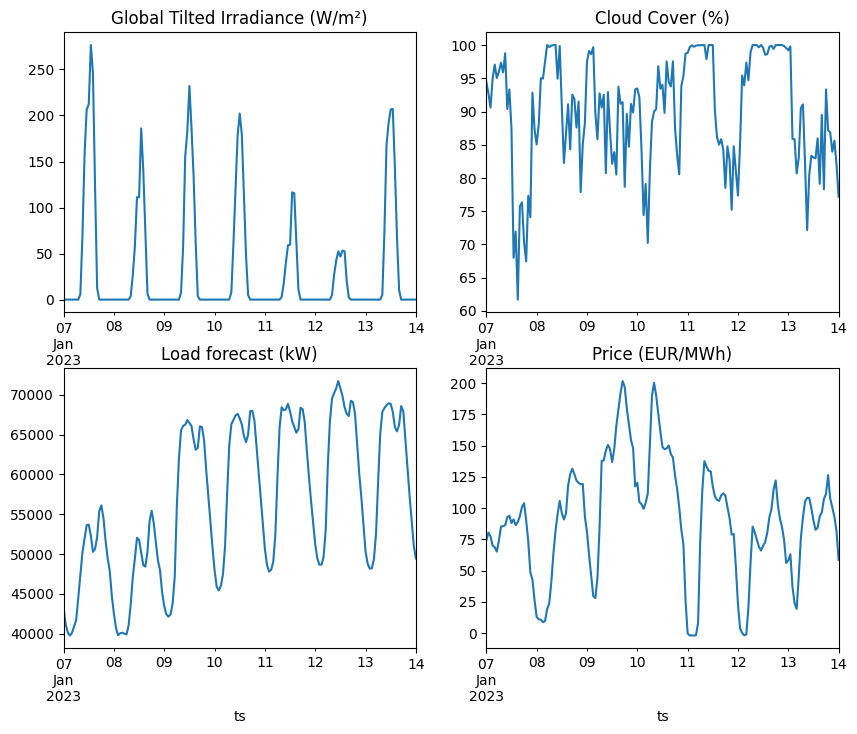

In [3]:
# Plot some variables over time
import matplotlib.pyplot as plt

df = data.loc[(data.index >= "2023-01-07") & (data.index <= "2023-01-14")]

features = [
    {"k": "global_tilted_irradiance_wm2", "t": "Global Tilted Irradiance (W/m²)"},
    {"k": "cloud_cover_perc", "t": "Cloud Cover (%)"},
    {"k": "load_kw", "t": "Load forecast (kW)"},
    {"k": "idc_av_price_eurmwh", "t": "Price (EUR/MWh)"},
]
plt.subplots(2, 2, figsize=(10, 8))
for idx, f in enumerate(features):
    ax = plt.subplot(2, 2, idx + 1)
    df[f["k"]].head()
    df[f["k"]].plot()
    plt.title(f["t"])


In [4]:
# Preprocess the data and create sets / loaders

# Copy the original
tdata = data.copy()

# We can only use EPEX values from the previous day
last_weather_col_idx = tdata.columns.tolist().index(weather_cols[-1])
first_weather_col_idx = tdata.columns.tolist().index(weather_cols[0])
today_cols = tdata.columns[0:last_weather_col_idx]
tdata[today_cols] = tdata[today_cols].shift(-24)
tdata = tdata[:-24]

# Fill N/A values
na_columns = tdata.columns[tdata.isna().any()].tolist()
for col in na_columns:
    tdata[col] = tdata[col].fillna(tdata[col].mean())

# Fill in missing daylight-saving hours
for idx in range(1, tdata.shape[0]):
    ts = tdata.index[idx]
    prev_ts = tdata.index[idx - 1]
    diff = (ts.hour - prev_ts.hour) % 24
    if diff != 1:
        iso_str = f"{ts.year}-{ts.month:02d}-{ts.day:02d}T{(ts.hour - 1):02d}:00:00"
        new_ts = pd.to_datetime(iso_str)
        tdata = pd.concat(
            [
                tdata,
                pd.DataFrame(tdata.loc[prev_ts].to_dict(), index=[new_ts]),
            ]
        )
tdata.sort_index(ascending=True, inplace=True)
tdata["hour"] = tdata.hour

# Note down the price amplitude before normalizing
price_mean = tdata["idc_av_price_eurmwh"].mean()
price_std = tdata["idc_av_price_eurmwh"].std()

# Normalize with min/max for the fixed date columns, mean for the rest
for c in tdata.columns[1:first_weather_col_idx]:
    tdata[c] = (tdata[c] - tdata[c].min()) / (tdata[c].max() - tdata[c].min())
tdata[tdata.columns[first_weather_col_idx:]] = (
    tdata[tdata.columns[first_weather_col_idx:]]
    - tdata[tdata.columns[first_weather_col_idx:]].mean()
) / tdata[tdata.columns[first_weather_col_idx:]].std()

# Create training and test rows
split_idx = int((0.8 * len(tdata)) // 24 * 24)
iso_str = f"{tdata.index[split_idx]}"[:10]
cutoff_date = pd.to_datetime(iso_str)
train_data = tdata.loc[(tdata.index < cutoff_date)]
test_data = tdata.loc[(tdata.index >= cutoff_date)]
train_rows = train_data.values.astype("float32")
test_rows = test_data.values.astype("float32")
price_idx = train_data.columns.tolist().index("idc_av_price_eurmwh")

In [5]:
# Create datasets and loaders

from numpy import ndarray
import torch
from torch.utils.data import DataLoader, TensorDataset


# Datasets are created from sliding windows
def create_dataset(
    data: ndarray, lookback_hours: int, predict_hours: int
) -> tuple[torch.Tensor, torch.Tensor]:
    X, y = [], []
    for i in range(lookback_hours, len(data) - predict_hours, 24):
        feature = data[i - lookback_hours : i]
        target = data[i : i + predict_hours][:, price_idx]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


# Create the sets
lookback_hours = 1 * 24
predict_hours = 1 * 24
X_train, y_train = create_dataset(train_rows, lookback_hours, predict_hours)
X_test, y_test = create_dataset(test_rows, lookback_hours, predict_hours)

# Loaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=8, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=8, shuffle=False)

/var/folders/mt/gxps7b2d6l3dps4vtczb2rh80000gn/T/ipykernel_96306/1157537686.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  return torch.tensor(X), torch.tensor(y)


In [6]:
# Create the model

from torch import nn, optim


class GRUModel(nn.Module):
    def __init__(self, input_size: int, num_layers=2, hidden_size=128, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Linear(hidden_size // 2, 8),
            nn.Linear(8, 1),
        )

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUModel(X_train.shape[2], 2, 256).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{trainable_params} trainable params")
print(f"GRU model ready (on device '{device}')")


646801 trainable params
GRU model ready (on device 'mps')


[1] Training loss: 0.656425, validation loss: 0.313992
[2] Training loss: 0.535739, validation loss: 0.279306
[3] Training loss: 0.542645, validation loss: 0.268405
[4] Training loss: 0.518863, validation loss: 0.285147
[5] Training loss: 0.504838, validation loss: 0.257566
[6] Training loss: 0.494905, validation loss: 0.252586
[7] Training loss: 0.477904, validation loss: 0.235549
[8] Training loss: 0.477236, validation loss: 0.243331
[9] Training loss: 0.464796, validation loss: 0.272076
[10] Training loss: 0.459516, validation loss: 0.246432
[11] Training loss: 0.455789, validation loss: 0.269399
[12] Training loss: 0.414420, validation loss: 0.250365
[13] Training loss: 0.425691, validation loss: 0.248357
[14] Training loss: 0.394960, validation loss: 0.247605
[15] Training loss: 0.385414, validation loss: 0.248646
[16] Training loss: 0.367574, validation loss: 0.236019
[17] Training loss: 0.356890, validation loss: 0.239809
No more improvement, stopping ...
Best validation loss: 0

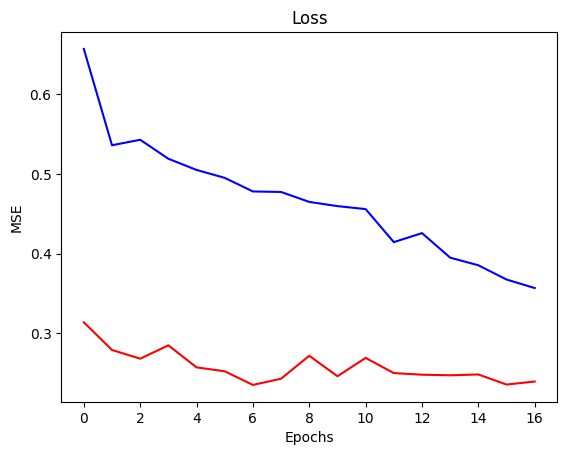

In [7]:
# Train the model

max_epochs = 200
best_val_loss = float("inf")
best_weights = None
patience = 10
patience_counter = 0

hist = {"train": [], "val": []}
for epoch in range(max_epochs):
    # Train the weights
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = loss_fn(output, torch.unsqueeze(y_batch, 2))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    hist["train"].append(train_loss)

    # Evaluate
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(torch.squeeze(X_batch))
            val_loss += loss_fn(output, torch.unsqueeze(y_batch, 2)).item()
    val_loss /= len(test_loader)
    hist["val"].append(val_loss)
    scheduler.step(val_loss)
    print(
        f"[{epoch + 1}] Training loss: {train_loss:.6f}, validation loss: {val_loss:.6f}"
    )

    # Stop early if there's no more improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("No more improvement, stopping ...")
            break
print(f"Best validation loss: {best_val_loss:.6f}")

# Display training progress
epochs = range(len(hist["train"]))
plt.figure()
plt.plot(epochs, hist["train"], "b", label="Training loss")
plt.plot(epochs, hist["val"], "r", label="Validation loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()

 Day-ahead: Ø 12.78 EUR  (σ = 33.99 EUR)
 Predicted: Ø 20.59 EUR  (σ = 20.23 EUR)
   Blended: Ø 12.14 EUR  (σ = 13.46 EUR)
               0.64 EUR better than day-ahead


<Figure size 1600x900 with 0 Axes>

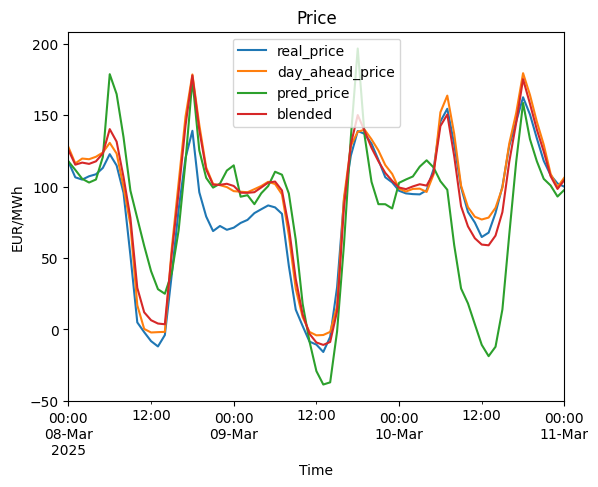

In [ ]:
# Evaluate the results

import numpy as np

assert best_weights is not None
model.load_state_dict(best_weights)

with torch.no_grad():
    model.cpu()
    y_pred_train = model(X_train).clone().detach().cpu().numpy()
    y_pred_train = y_pred_train.reshape(y_pred_train.shape[0] * y_pred_train.shape[1])
    y_pred_test = model(X_test).clone().detach().cpu().numpy()
    y_pred_test = y_pred_test.reshape(y_pred_test.shape[0] * y_pred_test.shape[1])

    train_plot = np.ones_like(tdata["idc_av_price_eurmwh"]) * np.nan
    train_plot[lookback_hours : y_pred_train.shape[0] + lookback_hours] = y_pred_train
    test_plot = np.ones_like(tdata["idc_av_price_eurmwh"]) * np.nan
    test_plot[
        len(train_rows) + lookback_hours : len(train_rows)
        + lookback_hours
        + y_pred_test.shape[0]
    ] = y_pred_test

    # Transform it back
    real_price = tdata["idc_av_price_eurmwh"].to_numpy() * price_std + price_mean
    daa_price = tdata["daa_price_eurmwh"].to_numpy() * price_std + price_mean
    pred_train_price = train_plot * price_std + price_mean
    pred_test_price = test_plot * price_std + price_mean

    # Calculate blended price
    blend_fac = 0.2
    blend_price = (1 - blend_fac) * daa_price + blend_fac * pred_test_price

    # Put everything in one data frame
    pdata = pd.DataFrame(
        {
            "intraday_price": real_price,
            "day_ahead_price": daa_price,
            # "pred_train": pred_train_price,
            "pred_price": pred_test_price,
            # "trivial": daa_price * 0.9 + daa_price.mean() * 0.1,
            "blended": blend_price,
        },
        index=tdata.index,
    )

    plt.figure(figsize=(16, 9))
    pdata.loc[(pdata.index >= "2025-03-08") & (pdata.index <= "2025-03-11")].plot(
        title="Price", xlabel="Time", ylabel="EUR/MWh"
    )

    # Print the average deviation
    daa_diff = pdata["intraday_price"] - pdata["day_ahead_price"]
    daa_dev_mean = daa_diff.abs().mean()
    daa_dev_std = daa_diff.abs().std()
    print(f" Day-ahead: Ø {daa_dev_mean:.2f} EUR  (σ = {daa_dev_std:.2f} EUR)")
    pred_diff = pdata["intraday_price"] - pdata["pred_price"]
    pred_dev_mean = pred_diff.abs().mean()
    pred_dev_std = pred_diff.abs().std()
    print(f" Predicted: Ø {pred_dev_mean:.2f} EUR  (σ = {pred_dev_std:.2f} EUR)")

    blend_diff = pdata["intraday_price"] - blend_price
    blend_dev_mean = blend_diff.abs().mean()
    blend_dev_std = blend_diff.abs().std()
    print(f"   Blended: Ø {blend_dev_mean:.2f} EUR  (σ = {blend_dev_std:.2f} EUR)")
    im = blend_dev_mean - daa_dev_mean
    print(
        f"               {abs(im):.2f} EUR {'better' if im < 0 else 'worse'} than day-ahead"
    )

    # triv_diff = pdata["intraday_price"] - pdata["trivial"]
    # triv_dev_mean = triv_diff.abs().mean()
    # triv_dev_std = triv_diff.abs().std()
    # print(f"   Trivial: {triv_dev_mean:.2f} EUR  (σ = {triv_dev_std:.2f} EUR)")
